In [62]:
############
#This program takes about 60 minutes to run
############

#Loading Package
import os

import time
import numpy as np
import scipy as sci
import scipy.io as sio
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras


from numpy.random import seed
seed(100)


import matplotlib.pyplot as plt


import time



In [60]:
# load raw data
raw = pd.read_csv(os.path.join('Implied_Volatility_Data_vFinal.csv'))
# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
raw.head(n=5)

Size of the dataset (row, col):  (125700, 5)


,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change
0,20140630,0.006678,0.184,0.745927,0.008462
1,20140630,0.006678,2.252,0.286911,0.002024
2,20140630,0.006678,0.124,0.902941,0.019707
3,20140630,0.006678,2.144,0.910926,0.006424
4,20140630,0.006678,1.412,0.885760,0.005673


## Construct the 3 variables for Regression Approach

In [3]:
# construct the 3 variables for regression
raw['x1'] = raw['SPX Return'] / np.sqrt(raw['Time to Maturity in Year'])
raw['x2'] = raw['SPX Return'] / np.sqrt(raw['Time to Maturity in Year']) * raw['Delta']
raw['x3'] = raw['x2'] * raw['Delta']

# Put the X and Y variable in data frame for regression
y = raw['Implied Volatility Change']
X = raw[['x1', 'x2', 'x3','SPX Return','Time to Maturity in Year','Delta']]

In [4]:
# Divide data into training set and test set(note that random seed is set)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

# Divide training set into training and validation set
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25,random_state=100)

## Feature Scaling

In [53]:
# Scale features based on Z-Score
scaler = StandardScaler()
scaler.fit(X_train)


X_scaled_train = scaler.transform(X_train)
X_scaled_vals = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

## Run Regression

In [6]:
# Run the regression on the training data
lr = LinearRegression(fit_intercept=False)
lr.fit(X_scaled_train[:,:3], y_train)

# Get the prediction
y_pred = lr.predict(X_scaled_test[:,:3])

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print('Test loss (MSE):', mse)

Test loss (MSE): 7.423167462421238e-05


## ML Approach

In [7]:
# Create ML Model
# Sequential function allows you to define your Neural Network in sequential order
# Within Sequential, use Dense function to define number of nodes, activation function and other related parameters 
# For more information regrading to activation functoin, please refer to https://keras.io/activations/
model = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (3,)),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                Dense(1)])

# Model summary function shows what you created in the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                80        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 941
Trainable params: 941
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Complie function allows you to choose your measure of loss and optimzer
# For other optimizer, please refer to https://keras.io/optimizers/
model.compile(loss = "mse",optimizer = "Adam")

In [42]:
# Checkpoint function is used here to periodically save a copy of the model. 
# Currently it is set to save the best performing model
checkpoint_cb = keras.callbacks.ModelCheckpoint("implied_vol_model_vFinal.h5",save_best_only = True)

# Early stopping allows you to stop your training early if no improvment is shown after cerain period
# Currently it is set at if no improvement occured in 1000 epochs, at the stop the model will also revert back to the best weight
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 1000,restore_best_weights = True)

# Remark: checkpoint could be redundant here as early stopping function can also help restoring to the best weight
# We put both here just to illustrate different ways to keep the best model
 

In [10]:
# train your model
# The fit function allows you to train a NN model. Here we have training data, number of epochs,batch size, validation data, 
# and callbacks as input
# Callback is an optional parameters that allow you to enable tricks for training such as early stopping and checkpoint

# Remarks: Altough we put 50000 epochs here, the model will stop its training once our early stopping criterion is triggered





start = time.time()
history=model.fit(X_scaled_train[:,3:6],y_train,epochs=50000, batch_size = 128, verbose = 0, validation_data=(X_scaled_vals[:,3:6],y_val),
                 callbacks=[checkpoint_cb, early_stopping_cb])
end = time.time()
# Print the running time measured in seconds
print(end - start)


2078.13751912117


In [11]:
# Load the best model you saved and calcuate MSE for testing set

model = keras.models.load_model("implied_vol_model_vFinal.h5")
mse_test = model.evaluate(X_scaled_test[:,3:6],y_test,verbose=0)

print('Test Loss(MSE):', mse_test)

Test Loss(MSE): 6.380462582455948e-05


In [12]:
# Calculate Gain Ratio

gain = 1 - mse_test/mse 

print('Gain Ratio:', gain)

Gain Ratio: 0.14046630164870189


## Review your results and export training history


In [45]:
#Export your training history for MSE
output = pd.DataFrame(history.history)
output.to_csv("mse_overtime.csv", index = False)

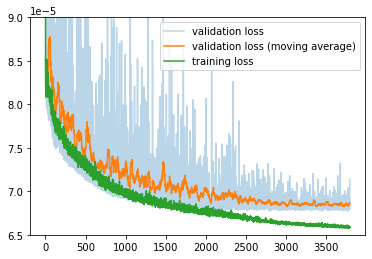

In [61]:
# Plot training history

df = pd.read_csv('mse_overtime.csv')

plt.plot(np.arange(len(df)), df['val_loss'], alpha = 0.3, label='validation loss')
plt.plot(np.arange(len(df)), df['val_loss'].rolling(25).mean(), label='validation loss (moving average)')
plt.plot(np.arange(len(df)), df['loss'], label='training loss')

plt.legend()
plt.ylim(0.000065,0.00009)
#plt.savefig('mse.png',bbox_inches='tight', transparent=True, dpi=300) 


plt.show()